In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

connection = {'host': 'hidden_host',
                      'database':'hidden_database',
                      'user':'hidden_user', 
                      'password':'hidden_password'
                     }


Проанализируем тест между группами 0 и 3 по обычному `CTR` и метрике `линеаризованных лайков`.

In [2]:
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-21' and '2022-09-27'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,3,115383,24,71,0.338028
1,3,10326,19,65,0.292308
2,0,38076,16,103,0.155340
3,3,36785,10,50,0.200000
4,0,151490,18,96,0.187500
...,...,...,...,...,...
27391,3,158023,10,30,0.333333
27392,3,13781,7,16,0.437500
27393,0,3681,9,35,0.257143
27394,3,122008,7,45,0.155556


Посчитаем общий `CTR` в контрольной группе. А также  поюзерную метрику `linearized_likes` в обеих группах.

In [3]:
control_ctr = df.query('exp_group == 0').likes.sum()/df.query('exp_group == 0').views.sum()
control_ctr

0.21035423136999318

In [4]:
df['linearized_likes'] = df.likes - control_ctr * df.views

T-test по `CTR`:

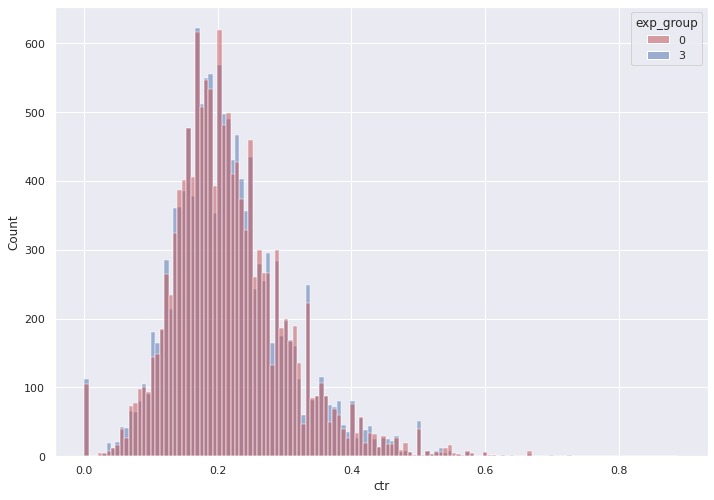

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [6]:
stats.ttest_ind(df.query('exp_group == 0').ctr,
                df.query('exp_group == 3').ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.3440264120165721, pvalue=0.7308290637050674)

---

T-test по `linearized_likes`:


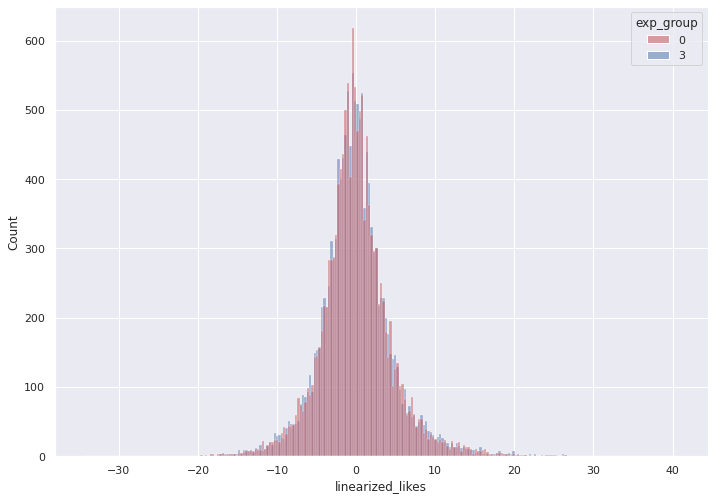

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [8]:
stats.ttest_ind(df.query('exp_group == 0').linearized_likes,
                df.query('exp_group == 3').linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-0.7198987765574395, pvalue=0.47159346397101576)

На обычном `CTR` T-test прокрасился и заметил разницу, а на линеаризованных лайках p-value стал еще меньше. Используя линеаризованную метрику, мы смогли заметить меньшие изменения. Метрика стала более чувствительной.
 
---

Проанализируем тест между группами 1 и 2 по обычному `CTR` и метрике `линеаризованных лайков`.

In [9]:
q2 = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-21' and '2022-09-27'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df2 = ph.read_clickhouse(q2, connection=connection)
df2

,exp_group,user_id,likes,views,ctr
0,1,109963,2,20,0.100000
1,1,138232,21,109,0.192661
2,1,49286,10,64,0.156250
3,1,145957,24,62,0.387097
4,2,131473,22,80,0.275000
...,...,...,...,...,...
26962,2,17146,7,37,0.189189
26963,1,30872,8,27,0.296296
26964,2,25383,7,40,0.175000
26965,1,57001,4,33,0.121212


Посчитаем общий `CTR` в контрольной группе. А также  поюзерную метрику `linearized_likes` в обеих группах.

In [10]:
control_ctr2 = df2.query('exp_group == 1').likes.sum()/df2.query('exp_group == 1').views.sum()
control_ctr2

0.21688461804926726

In [11]:
df2['linearized_likes'] = df2.likes - control_ctr2 * df2.views

T-test по `CTR`:

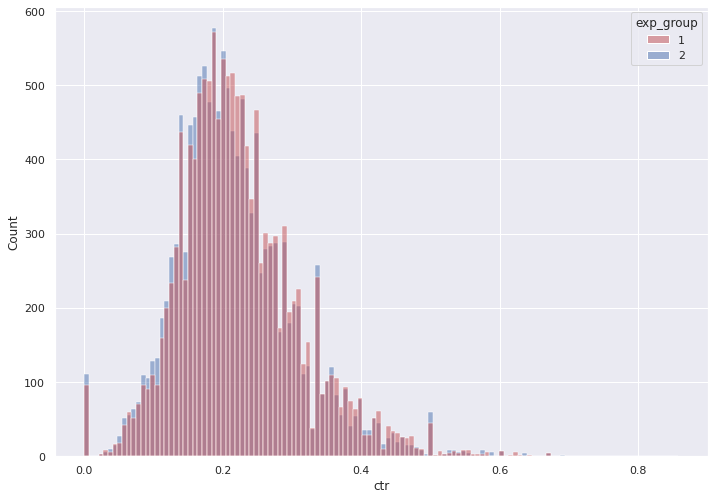

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [13]:
stats.ttest_ind(df2.query('exp_group == 1').ctr,
                df2.query('exp_group == 2').ctr,
                equal_var=False)

Ttest_indResult(statistic=4.826579789306613, pvalue=1.3965740773012885e-06)

---

T-test по `linearized_likes`:


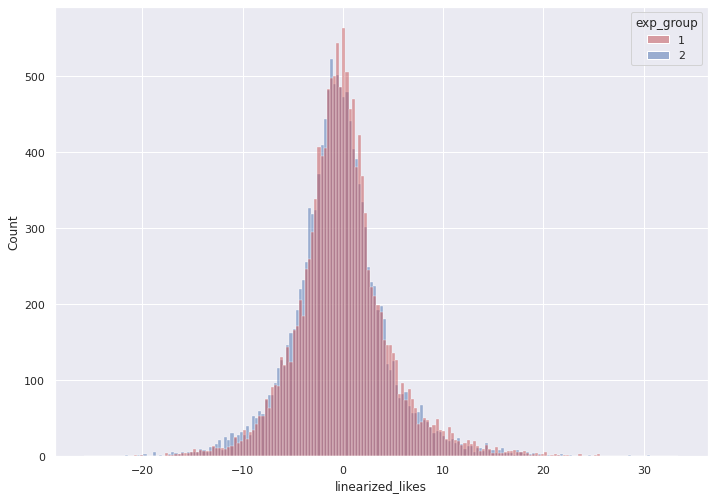

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [15]:
stats.ttest_ind(df2.query('exp_group == 1').linearized_likes,
                df2.query('exp_group == 2').linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.757466093254311, pvalue=8.631200390318467e-09)

На обычном `CTR` T-test не прокрасился, разница между тестовой и контрольной группами не выявлена. 
На линеаризованной метрике T-test уверенно прокрасился, что говорит нам о статистически значимых отличиях в группах. Линеаризация сделала метрику более чувствительной и мы смогли выявить различия.